In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
def graficar(s: pd.Series, t, linea_cero=False):
    fig, ax = plt.subplots(figsize=[8,4])
    s.plot(ax=ax)
    ax.set_title(t)
    if linea_cero:
        ax.axhline(y=0,color='grey',linestyle='--')

def graficar2(s1: pd.Series, t1,s2: pd.Series, t2, linea_cero=False):
    fig, ax = plt.subplots(1,2,figsize=[10,4])
    s1.plot(ax=ax[0])
    s2.plot(ax=ax[1])
    ax[0].set_title(t1)
    ax[1].set_title(t2)
    if linea_cero:
        ax[0].axhline(y=0,color='grey',linestyle='--')
        ax[1].axhline(y=0,color='grey',linestyle='--')

# Carga de datos
Se extrayeron los datos de [https://databank.bancomundial.org/](https://databank.bancomundial.org/)

Indicadores Macroeconómicos

In [3]:
df_wb = pd.read_csv('../data/WBdataset.csv')
df_wb.head()

,país Name,país Code,tiempo,FP.CPI.TOTL,NY.GDP.MKTP.KD,NE.TRD.GNFS.ZS,NE.EXP.GNFS.ZS,NE.IMP.GNFS.ZS,NE.CON.GOVT.ZS,NE.GDI.FTOT.ZS,NV.IND.TOTL.ZS,NV.IND.MANF.ZS,SL.UEM.TOTL.NE.ZS,NV.AGR.TOTL.ZS
0,Alemania,DEU,1960,24.646074,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Alemania,DEU,1961,25.211375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Alemania,DEU,1962,25.928205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Alemania,DEU,1963,26.697485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Alemania,DEU,1964,27.321066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Precio de Commodities

In [4]:
df_com = pd.read_csv('../data/com_sp.csv',sep=';')
df_com.head()

,year,oil,gold,copper,sp500
0,1960,8.514978,184.247397,3545.761145,578.91
1,1961,8.045025,180.628741,3244.062298,585.77
2,1962,7.646138,177.219364,3245.299218,672.96
3,1963,7.686329,179.808866,3309.993923,625.55
4,1964,7.327570,177.377723,4900.644952,723.17


# Descripción

Características de dataset de macroeconomia

In [5]:
df_wb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3720 entries, 0 to 3719
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   país Name          3720 non-null   object 
 1   país Code          3720 non-null   object 
 2   tiempo             3720 non-null   int64  
 3   FP.CPI.TOTL        3422 non-null   float64
 4   NY.GDP.MKTP.KD     3270 non-null   float64
 5   NE.TRD.GNFS.ZS     3167 non-null   float64
 6   NE.EXP.GNFS.ZS     3167 non-null   float64
 7   NE.IMP.GNFS.ZS     3167 non-null   float64
 8   NE.CON.GOVT.ZS     3150 non-null   float64
 9   NE.GDI.FTOT.ZS     3093 non-null   float64
 10  NV.IND.TOTL.ZS     2648 non-null   float64
 11  NV.IND.MANF.ZS     2566 non-null   float64
 12  SL.UEM.TOTL.NE.ZS  2333 non-null   float64
 13  NV.AGR.TOTL.ZS     2648 non-null   float64
dtypes: float64(11), int64(1), object(2)
memory usage: 407.0+ KB


Reemplazo de nombres en el DataFrame de Macroeconomia para mejor interpretación

In [6]:
names = {
    'país Name'             : 'country',
    'país Code'             : 'iso',
    'tiempo'                : 'year',
    'FP.CPI.TOTL'           : 'cpi',
    'NY.GDP.MKTP.KD'        : 'rgdp',
    'NE.TRD.GNFS.ZS'        : 'trade',
    'NE.EXP.GNFS.ZS'        : 'exports',
    'NE.IMP.GNFS.ZS'        : 'imports',
    'NE.CON.GOVT.ZS'        : 'ggfce',
    'NE.GDI.FTOT.ZS'        : 'gfcf',
    'NV.IND.TOTL.ZS'        : 'industry',
    'NV.IND.MANF.ZS'        : 'manufact',
    'SL.UEM.TOTL.NE.ZS'     : 'unempl',
    'NV.AGR.TOTL.ZS'        : 'agriculture'
}
df_wb = df_wb.rename(columns=names)

In [7]:
df_wb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3720 entries, 0 to 3719
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      3720 non-null   object 
 1   iso          3720 non-null   object 
 2   year         3720 non-null   int64  
 3   cpi          3422 non-null   float64
 4   rgdp         3270 non-null   float64
 5   trade        3167 non-null   float64
 6   exports      3167 non-null   float64
 7   imports      3167 non-null   float64
 8   ggfce        3150 non-null   float64
 9   gfcf         3093 non-null   float64
 10  industry     2648 non-null   float64
 11  manufact     2566 non-null   float64
 12  unempl       2333 non-null   float64
 13  agriculture  2648 non-null   float64
dtypes: float64(11), int64(1), object(2)
memory usage: 407.0+ KB


Características de dataset de commodities y sp500

In [8]:
df_com.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    62 non-null     int64  
 1   oil     62 non-null     float64
 2   gold    62 non-null     float64
 3   copper  62 non-null     float64
 4   sp500   62 non-null     float64
dtypes: float64(4), int64(1)
memory usage: 2.5 KB


Listado de países:

In [9]:
paises = df_wb.iso.unique()
print(paises)

['DEU' 'AUS' 'AUT' 'BGD' 'BEL' 'BOL' 'BRA' 'CAN' 'CHL' 'CHN' 'COL' 'CRI'
 'HRV' 'DNK' 'ECU' 'SLV' 'ESP' 'USA' 'EST' 'RUS' 'FIN' 'FRA' 'GRC' 'GTM'
 'HND' 'HUN' 'IND' 'IDN' 'IRL' 'ISL' 'ISR' 'ITA' 'JPN' 'JOR' 'KEN' 'LTU'
 'LUX' 'MYS' 'MLT' 'MAR' 'MEX' 'NGA' 'NOR' 'NLD' 'PAK' 'PAN' 'PRY' 'PER'
 'POL' 'PRT' 'GBR' 'EGY' 'KOR' 'ROU' 'SWE' 'CHE' 'TUR' 'URY' 'VNM' 'NZL']


Unión de datasets por país y año

# Preprocesamiento

Completar datos interpolando

In [10]:
def preprocesar(df : pd.DataFrame, df2 : pd.DataFrame):
    paises = df.iso.unique()
    df_r = pd.DataFrame()
    for pais in paises:
        df_n = df[df.iso==pais].copy()
        #Fija year como indice
        df_n = df_n.astype({'year': np.int16})
        df_n = df_n.set_index('year')
        #interpola datos faltantes en la serie
        df_n = df_n.interpolate()
        #calcula el ratio de crecimiento del PBI real
        df_n['rgdp_growth'] = df_n['rgdp'].pct_change()*100.0
        df_n = df_n.drop('rgdp',axis=1)
        #calcula la inflacion a partir del cpi
        df_n['infl_cpi'] = df_n['cpi'].pct_change()*100.0
        df_n = df_n.drop('cpi',axis=1)
        #escala logaritmica
        #df_n['rgdp'] = np.log10(df_n['rgdp'])
        #df_n['cpi'] = np.log10(df_n['cpi'])
        #Une con el data frame 2
        df_n = pd.merge(left=df_n, right=df2, left_on='year',right_on='year')
        df_r = df_r.append(df_n)
    #escala logaritmica
    #df_r['oil'] = np.log10(df_r['oil'])
    #df_r['gold'] = np.log10(df_r['gold'])
    #df_r['copper'] = np.log10(df_r['copper'])
    #df_r['sp500'] = np.log10(df_r['sp500'])
    #Eliminando outliers por hiperinflacion
    q1 = df_r['infl_cpi'].quantile(q=0.25)
    q3 = df_r['infl_cpi'].quantile(q=0.75)
    iqr = q3 - q1 
    #lower = q1 - 1.5 * iqr
    min_v = df_r['infl_cpi'].min()
    upper = q3 + 1.5 * iqr
    df_r['infl_cpi'] = np.clip(df_r['infl_cpi'],min_v,upper)
    df_r = df_r.set_index('year')
    #elimina filas con datos faltantes en los extremos
    df_r = df_r.dropna()
    return df_r

In [11]:
df = preprocesar(df_wb,df_com)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2145 entries, 1991 to 2021
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      2145 non-null   object 
 1   iso          2145 non-null   object 
 2   trade        2145 non-null   float64
 3   exports      2145 non-null   float64
 4   imports      2145 non-null   float64
 5   ggfce        2145 non-null   float64
 6   gfcf         2145 non-null   float64
 7   industry     2145 non-null   float64
 8   manufact     2145 non-null   float64
 9   unempl       2145 non-null   float64
 10  agriculture  2145 non-null   float64
 11  rgdp_growth  2145 non-null   float64
 12  infl_cpi     2145 non-null   float64
 13  oil          2145 non-null   float64
 14  gold         2145 non-null   float64
 15  copper       2145 non-null   float64
 16  sp500        2145 non-null   float64
dtypes: float64(15), object(2)
memory usage: 301.6+ KB


In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
trade,2145.0,74.896136,49.952632,9.135846,45.184870,60.934890,85.360496,388.847728
exports,2145.0,37.027529,26.590419,4.990050,21.330559,29.666684,43.315161,212.117152
imports,2145.0,37.868607,23.979848,3.886755,22.775000,30.935832,43.624618,176.730577
ggfce,2145.0,16.063157,5.310353,0.911235,11.807586,16.552876,19.779207,27.993926
gfcf,2145.0,22.360908,5.631194,5.811191,18.949956,21.815303,25.015774,54.948270
industry,2145.0,27.161713,6.606345,10.426719,22.656442,26.378479,30.449196,61.843617
manufact,2145.0,16.170997,4.947386,4.554389,12.842633,15.954730,19.061241,37.207946
unempl,2145.0,7.055245,3.924116,0.400000,4.110000,6.190000,9.090000,27.469999
agriculture,2145.0,8.263357,7.729688,0.187098,2.367353,5.019559,12.480077,39.388041
rgdp_growth,2145.0,3.288836,3.691310,-17.944864,1.619394,3.460989,5.191932,25.176245


# Guardar

In [14]:
df.to_csv('../data/wb_dataset_prep.csv')

In [15]:
print(df_wb['iso'].unique())

['DEU' 'AUS' 'AUT' 'BGD' 'BEL' 'BOL' 'BRA' 'CAN' 'CHL' 'CHN' 'COL' 'CRI'
 'HRV' 'DNK' 'ECU' 'SLV' 'ESP' 'USA' 'EST' 'RUS' 'FIN' 'FRA' 'GRC' 'GTM'
 'HND' 'HUN' 'IND' 'IDN' 'IRL' 'ISL' 'ISR' 'ITA' 'JPN' 'JOR' 'KEN' 'LTU'
 'LUX' 'MYS' 'MLT' 'MAR' 'MEX' 'NGA' 'NOR' 'NLD' 'PAK' 'PAN' 'PRY' 'PER'
 'POL' 'PRT' 'GBR' 'EGY' 'KOR' 'ROU' 'SWE' 'CHE' 'TUR' 'URY' 'VNM' 'NZL']


In [16]:
df_wb = df_wb.set_index('year')

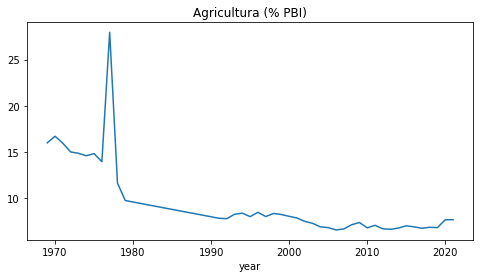

In [17]:
graficar(df[df.iso=='PER']['agriculture'],'Agricultura (% PBI)')

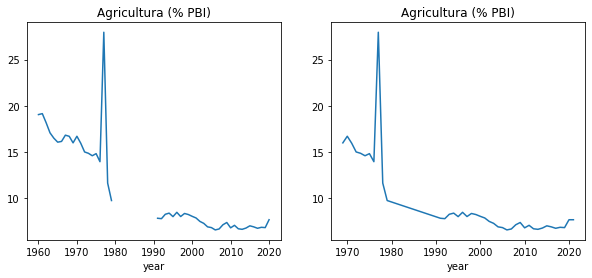

In [18]:
graficar2(df_wb[df_wb.iso=='PER']['agriculture'],'Agricultura (% PBI)',df[df.iso=='PER']['agriculture'],'Agricultura (% PBI)')

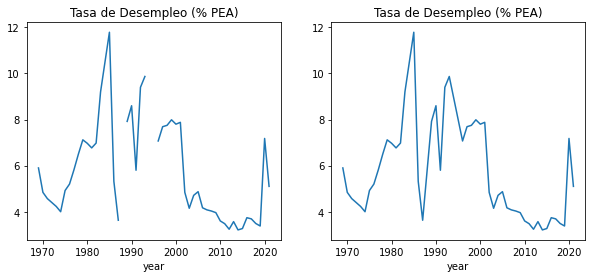

In [19]:
graficar2(df_wb[df_wb.iso=='PER']['unempl'],'Tasa de Desempleo (% PEA)',df[df.iso=='PER']['unempl'],'Tasa de Desempleo (% PEA)')

In [20]:
df_p = pd.read_csv('../data/wb_dataset_prep.csv')
df_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2145 entries, 0 to 2144
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   year         2145 non-null   int64  
 1   country      2145 non-null   object 
 2   iso          2145 non-null   object 
 3   trade        2145 non-null   float64
 4   exports      2145 non-null   float64
 5   imports      2145 non-null   float64
 6   ggfce        2145 non-null   float64
 7   gfcf         2145 non-null   float64
 8   industry     2145 non-null   float64
 9   manufact     2145 non-null   float64
 10  unempl       2145 non-null   float64
 11  agriculture  2145 non-null   float64
 12  rgdp_growth  2145 non-null   float64
 13  infl_cpi     2145 non-null   float64
 14  oil          2145 non-null   float64
 15  gold         2145 non-null   float64
 16  copper       2145 non-null   float64
 17  sp500        2145 non-null   float64
dtypes: float64(15), int64(1), object(2)
memory usage

In [21]:
df_p.describe()

,year,trade,exports,imports,ggfce,gfcf,industry,manufact,unempl,agriculture,rgdp_growth,infl_cpi,oil,gold,copper,sp500
count,2145.000000,2145.000000,2145.000000,2145.000000,2145.000000,2145.000000,2145.000000,2145.000000,2145.000000,2145.000000,2145.000000,2145.000000,2145.000000,2145.000000,2145.000000,2145.000000
mean,2002.012587,74.896136,37.027529,37.868607,16.063157,22.360908,27.161713,16.170997,7.055245,8.263357,3.288836,6.243251,48.770330,800.116509,4507.964387,1722.748014
std,12.547348,49.952632,26.590419,23.979848,5.310353,5.631194,6.606345,4.947386,3.924116,7.729688,3.691310,6.398715,25.392491,451.951668,2167.138692,929.841604
min,1969.000000,9.135846,4.990050,3.886755,0.911235,5.811191,10.426719,4.554389,0.400000,0.187098,-17.944864,-4.478103,5.212236,154.823500,1951.648771,363.590000
25%,1993.000000,45.184870,21.330559,22.775000,11.807586,18.949956,22.656442,12.842633,4.110000,2.367353,1.619394,1.832994,23.648309,417.932999,2545.072356,892.120000
50%,2003.000000,60.934890,29.666684,30.935832,16.552876,21.815303,26.378479,15.954730,6.190000,5.019559,3.460989,3.683329,45.528322,593.170116,3576.915524,1742.490000
75%,2012.000000,85.360496,43.315161,43.624618,19.779207,25.015774,30.449196,19.061241,9.090000,12.480077,5.191932,8.575135,67.152391,1224.664250,6342.227603,2229.580000
max,2021.000000,388.847728,212.117152,176.730577,27.993926,54.948270,61.843617,37.207946,27.469999,39.388041,25.176245,21.763640,95.311523,1789.414970,9264.169006,4239.200000


array([[<AxesSubplot:title={'center':'year'}>,
        <AxesSubplot:title={'center':'trade'}>,
        <AxesSubplot:title={'center':'exports'}>,
        <AxesSubplot:title={'center':'imports'}>],
       [<AxesSubplot:title={'center':'ggfce'}>,
        <AxesSubplot:title={'center':'gfcf'}>,
        <AxesSubplot:title={'center':'industry'}>,
        <AxesSubplot:title={'center':'manufact'}>],
       [<AxesSubplot:title={'center':'unempl'}>,
        <AxesSubplot:title={'center':'agriculture'}>,
        <AxesSubplot:title={'center':'rgdp_growth'}>,
        <AxesSubplot:title={'center':'infl_cpi'}>],
       [<AxesSubplot:title={'center':'oil'}>,
        <AxesSubplot:title={'center':'gold'}>,
        <AxesSubplot:title={'center':'copper'}>,
        <AxesSubplot:title={'center':'sp500'}>]], dtype=object)

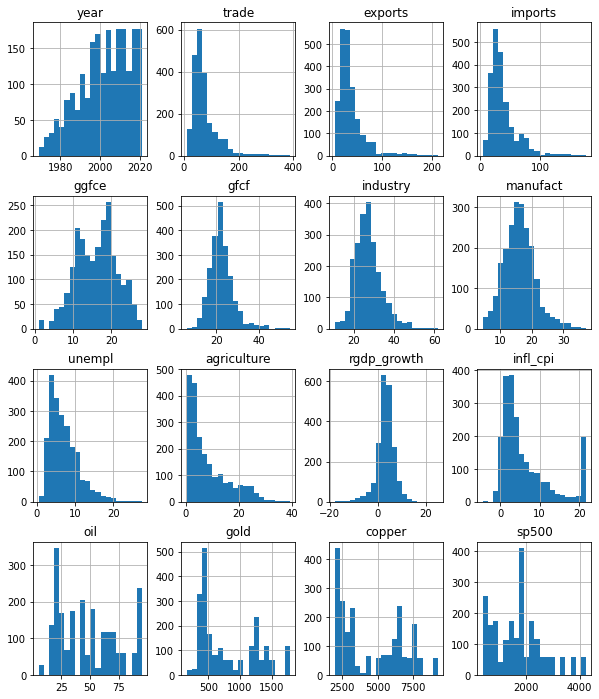

In [22]:
df_p.hist(bins=20,figsize=(10,12))

In [23]:
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS

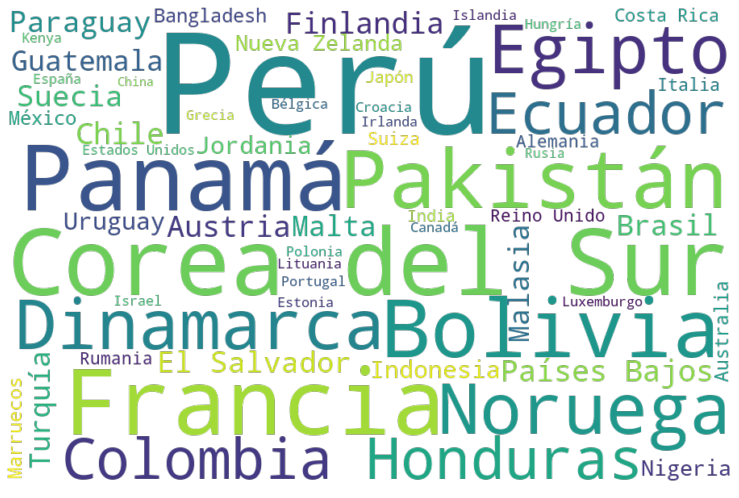

In [24]:
#text = " ".join(i for i in df_p.iso)
iso = df_p['country'].value_counts().to_dict()

wordcloud = WordCloud(mode = "RGBA",max_words=60, background_color=None,width=900,height=600).generate_from_frequencies(iso)
plt.figure( figsize=(13,9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Text(0, 0.5, 'Países')

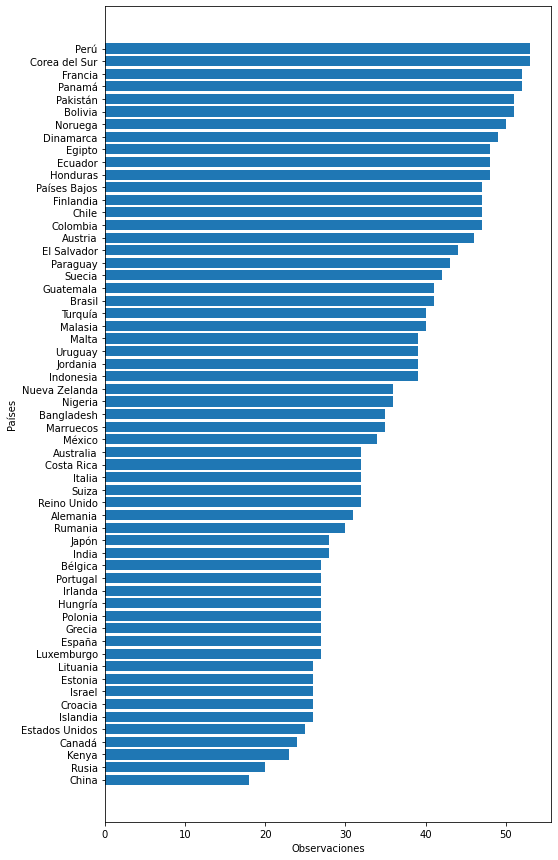

In [25]:
paises = df_p['country'].value_counts().sort_values(ascending=True)
labels = paises.index
cant = paises.values

fig,ax = plt.subplots(figsize=(8,15))
ax.barh(labels,cant)
ax.set_xlabel("Observaciones")
ax.set_ylabel("Países")